In [1]:
import numpy as np
import pandas as pd
import os,sys,inspect
import scipy.stats as stats
import scipy.optimize as opt
from scipy.stats import norm
import scipy.integrate as integrate
from scipy.io import loadmat
import econtools 
import econtools.metrics as mt
import statsmodels.discrete.discrete_model as sm
import matplotlib.pyplot as plt
import itertools as it
import copy
import importlib
import warnings
warnings.filterwarnings('ignore')
import seaborn as sns

# my functions
dirpath = os.getcwd()
i = 0
while(os.path.basename(dirpath) != "NU450_HW") and (i<=10):
    dirpath = os.path.dirname(dirpath)
    i = i + 1
targetdir = dirpath + '/450-3-HW1'
if targetdir not in sys.path:
    sys.path.insert(0,targetdir)

from single_agent_dynamics import est_func_step1_transitions
from single_agent_dynamics import est_func_step2_estimate_EV
from single_agent_dynamics import ols_approach
from single_agent_dynamics import agent_choices
importlib.reload(est_func_step1_transitions)
importlib.reload(est_func_step2_estimate_EV)
importlib.reload(ols_approach)
importlib.reload(agent_choices)

<module 'single_agent_dynamics.agent_choices' from '/Users/jingyuanwang/GitHub/NU450_HW/450-3-HW1/single_agent_dynamics/agent_choices.py'>

In [2]:
%pdb ON

Automatic pdb calling has been turned ON


# Path

In [3]:
datapath = '/Users/jingyuanwang/Dropbox/Course/ECON/IO/NU450/NU450_HW/450-3-HW1/data'

# import data

In [4]:
df = pd.read_csv(datapath + '/ddc_pset.csv')

# ------------------------------------------------------------------ 
# DATA CLEANING: cut state var into grid and show the data pattern  
# ------------------------------------------------------------------ 
# ---- number of obs in each bin ---------- 
(31.4, 35.3]     3000
(35.3, 39.2]     5000
(39.2, 43.1]    15000
(43.1, 47.0]    24000
(47.0, 50.9]    26000
(50.9, 54.8]    18000
(54.8, 58.7]     7000
(58.7, 62.6]     2000
Name: rc, dtype: int64
# ---- average probability in each bin ---------- 


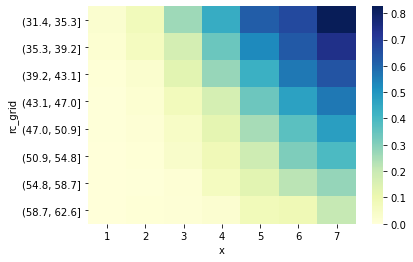

ERROR !!!!! maximum possible value exceed the lower bound, min(cdf_ub) = 0.8979256822861432
ERROR !!!!! minimum possible value exceed the upper bound, max(cdf_lp) = 0.09453891650935248
# ---- transition matrix for RC ------------- 


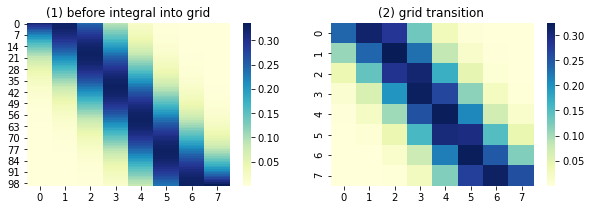

# ---- transition matrix for all states ---------- 


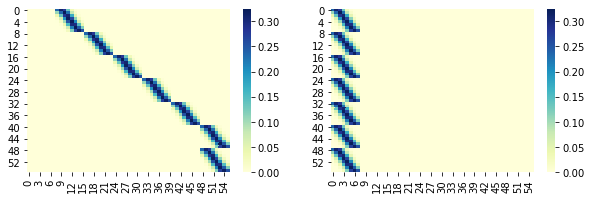

In [5]:
n_grid = 8
data = agent_choices.observations(df, n_rc_grids = n_grid, weight= True)

# MLE approach

In [6]:
theta0 = np.ones(2)
estimation = agent_choices.estimation(data)

## fixed point

In [8]:
estimation.get_loglikelihood(theta0)

704371.6067347014

In [9]:
%timeit opt.minimize(estimation.get_loglikelihood, theta0, method='Nelder-Mead')
res1 =opt.minimize(estimation.get_loglikelihood, theta0, method='Nelder-Mead')

1.47 s ± 71.7 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [10]:
res1.x

array([0.41180604, 0.15671191])

In [11]:
EV, u, transition = estimation._get_continuation_values(res1.x, method='fixed_point')

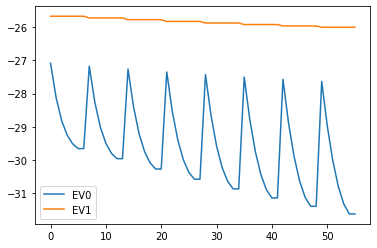

In [12]:
# reshape to RC = min grid, x = 1,2,3... ; then RC = 2nd grid, x = ...  
# To show the pattern more clear!
toplot_EV0 = EV['0'].reshape( (7,n_grid) , order ='C').reshape( (1,7*n_grid), order = 'F' )
toplot_EV1 = EV['1'].reshape( (7,n_grid) , order ='C').reshape( (1,7*n_grid), order = 'F' )
plt.plot(toplot_EV0.flatten(), label='EV0')
plt.plot(toplot_EV1.flatten(), label= 'EV1')
plt.legend()

## HM

In [13]:
%timeit opt.minimize(lambda x: estimation.get_loglikelihood(x, method = 'H-Minversion'),  \
                           theta0, method='Nelder-Mead')
res2 =opt.minimize(lambda x: estimation.get_loglikelihood(x, method = 'H-Minversion'),  \
                           theta0, method='Nelder-Mead')

10.6 ms ± 338 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [14]:
print('from HW inversion {}'.format(res2.x) )
print('from fixed point  {}'.format(res1.x) )

from HW inversion [0.41175426 0.15670817]
from fixed point  [0.41180604 0.15671191]


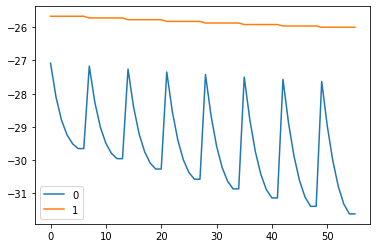

In [15]:
EV, u, transition = estimation._get_continuation_values(res2.x, method='fixed_point')
toplot_EV0 = EV['0'].reshape( (7,n_grid) , order ='C').reshape( (1,n_grid*7), order = 'F' )
toplot_EV1 = EV['1'].reshape( (7,n_grid) , order ='C').reshape( (1,n_grid*7), order = 'F' )
plt.plot(toplot_EV0.flatten(), label='0')
plt.plot(toplot_EV1.flatten(), label= '1')
plt.legend()

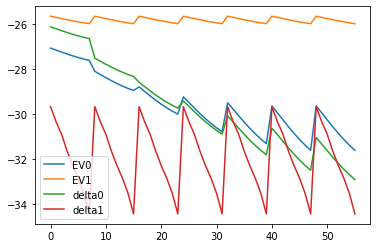

In [16]:
plt.plot(EV['0'], label='EV0')
plt.plot(EV['1'], label= 'EV1')
plt.plot(u['0']+0.95*EV['0'], label='delta0')
plt.plot(u['1']+0.95*EV['1'], label= 'delta1')
plt.legend()

# OLS approach

In [17]:
n_grid = 5

# ------------------------------------------------------------------ 
# DATA CLEANING: cut state var into grid and show the data pattern  
# ------------------------------------------------------------------ 
# ---- number of obs in each bin ---------- 
(31.4, 37.64]      5000
(37.64, 43.88]    20000
(43.88, 50.12]    41000
(50.12, 56.36]    29000
(56.36, 62.6]      5000
Name: rc, dtype: int64
# ---- average probability in each bin ---------- 


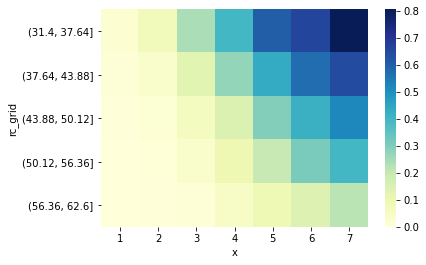

ERROR !!!!! maximum possible value exceed the lower bound, min(cdf_ub) = 0.8979256822861432
ERROR !!!!! minimum possible value exceed the upper bound, max(cdf_lp) = 0.09453891650935248
# ---- transition matrix for RC ------------- 


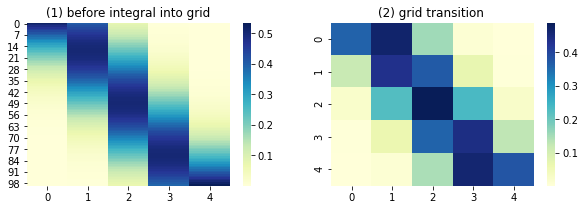

# ---- transition matrix for all states ---------- 


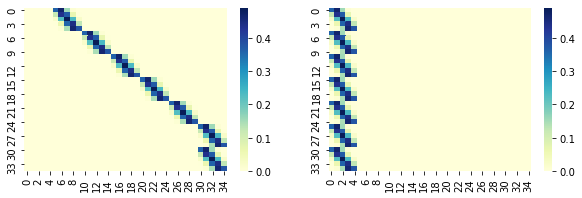

In [18]:
data2 = agent_choices.observations(df, n_rc_grids = n_grid, weight= True)

In [19]:
importlib.reload(ols_approach)
ols_est = ols_approach.ols_scott2003(data2)
ols_est._construct_reg_df()

## state level reg

In [20]:
df_toreg = ols_est.df2reg_statelevel.copy()

# merge in transition probability
rc_transition = ols_est.transition['1'][:n_grid,:n_grid].reshape( (n_grid*n_grid, ) )

transition_prob = pd.DataFrame(np.array([np.arange(n_grid).repeat(n_grid), rc_transition]).T, 
             columns = ['rc_grid_id','rc_transition'])

transition_prob = (pd.concat( [transition_prob]*7, keys=np.arange(7) )
                   .reset_index()
                   .rename(columns = {'level_0':'x'})
                   .drop(columns = 'level_1') )

df_toreg = df_toreg.merge(transition_prob, on = ['x','rc_grid_id'])

# drop inf
df_toreg = df_toreg.replace([np.inf, -np.inf], np.nan).dropna()

In [21]:
df_toreg['weight'] = df_toreg['num_of_obs'] * df_toreg['rc_transition']

In [22]:
mt.reg(df_toreg , 'y', ['x', 'rc'] )

Dependent variable:	y
N:			580
R-squared:		0.7950
Estimation method:	OLS
VCE method:		Standard (Homosk.)
    coeff    se       t   p>t CI_low CI_high
x  -0.384 0.014 -27.927 0.000 -0.411  -0.357
rc  0.148 0.001 128.456 0.000  0.145   0.150

In [23]:
mt.reg(df_toreg , 'y', ['x', 'rc'] , awt_name='weight')

Dependent variable:	y
N:			580
R-squared:		0.9831
Estimation method:	OLS
VCE method:		Standard (Homosk.)
    coeff    se       t   p>t CI_low CI_high
x  -0.439 0.013 -34.727 0.000 -0.464  -0.414
rc  0.152 0.001 159.088 0.000  0.150   0.154

## obs level reg

In [24]:
df_toreg2 = ols_est.df2reg_obs_level.copy()
df_toreg2 = df_toreg2.replace([np.inf, -np.inf], np.nan).dropna()

In [ ]:
%timeit mt.reg(df_toreg2, 'y', ['x', 'rc'] )
mt.reg(df_toreg2, 'y', ['x', 'rc'] )

In [ ]:
# try grid mean
mt.reg(df_toreg2, 'y', ['x', 'grid_mean'] )

In [ ]:
res = mt.reg(df_toreg2, 'y', ['x', 'rc'] )

In [ ]:
res.beta

# Appendix: check the EV from 2 methods

In [ ]:
EV1, _, _ = estimation._get_continuation_values(res1.x, method='fixed_point')
EV2, _, _ = estimation._get_continuation_values(res1.x, method='H-Minversion')

In [ ]:
plt.plot(EV1['0'], label= 'EV0, from fixed_point')
plt.plot(EV1['1'], label= 'EV1, from fixed_point')
plt.plot(EV2['0'], label= 'EV0, from H-Minversion')
plt.plot(EV2['1'], label= 'EV1, from H-Minversion')
plt.legend()